# Support Vector Machine

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR, SVC

## Generate the data

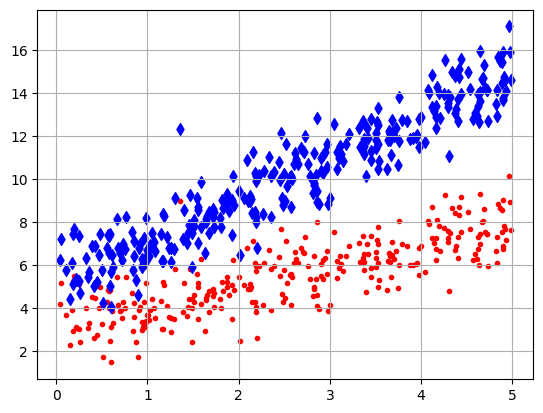

In [2]:
N = 300

a1 = 1 
b1 = 3

a2 = 2
b2 = 5

x = np.random.uniform(0, 5, N) # 50 [0,5]
noise = np.random.normal(0, 1, N)

# y = x + 3
y1base = a1 * x + b1
# y = 2x + 5
y2base = a2 * x + b2

y1 = y1base + noise
y2 = y2base + noise

plt.grid()
plt.scatter(x, y1, marker = '.', color = 'r')
plt.scatter(x, y2, marker = 'd', color = 'b')

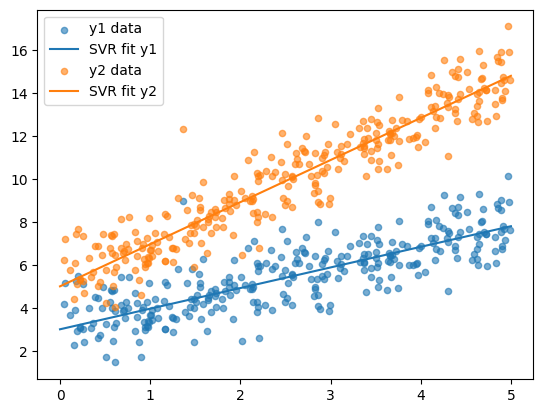

In [3]:
X = x.reshape(-1, 1)
# pipelines: scale X -> SVR
svr1 = make_pipeline(StandardScaler(), SVR(kernel="linear", C=100.0, epsilon=0.1))
svr2 = make_pipeline(StandardScaler(), SVR(kernel="linear", C=100.0, epsilon=0.1))
svr1.fit(X, y1)
svr2.fit(X, y2)

# predictions for a smooth curve
x_fit = np.linspace(0, 5, 400).reshape(-1, 1)
y1_hat = svr1.predict(x_fit)
y2_hat = svr2.predict(x_fit)

plt.scatter(x, y1, s=20, alpha=0.6, label="y1 data")
plt.plot(x_fit, y1_hat, label="SVR fit y1")
plt.scatter(x, y2, s=20, alpha=0.6, label="y2 data")
plt.plot(x_fit, y2_hat, label="SVR fit y2")
plt.legend()
plt.show()

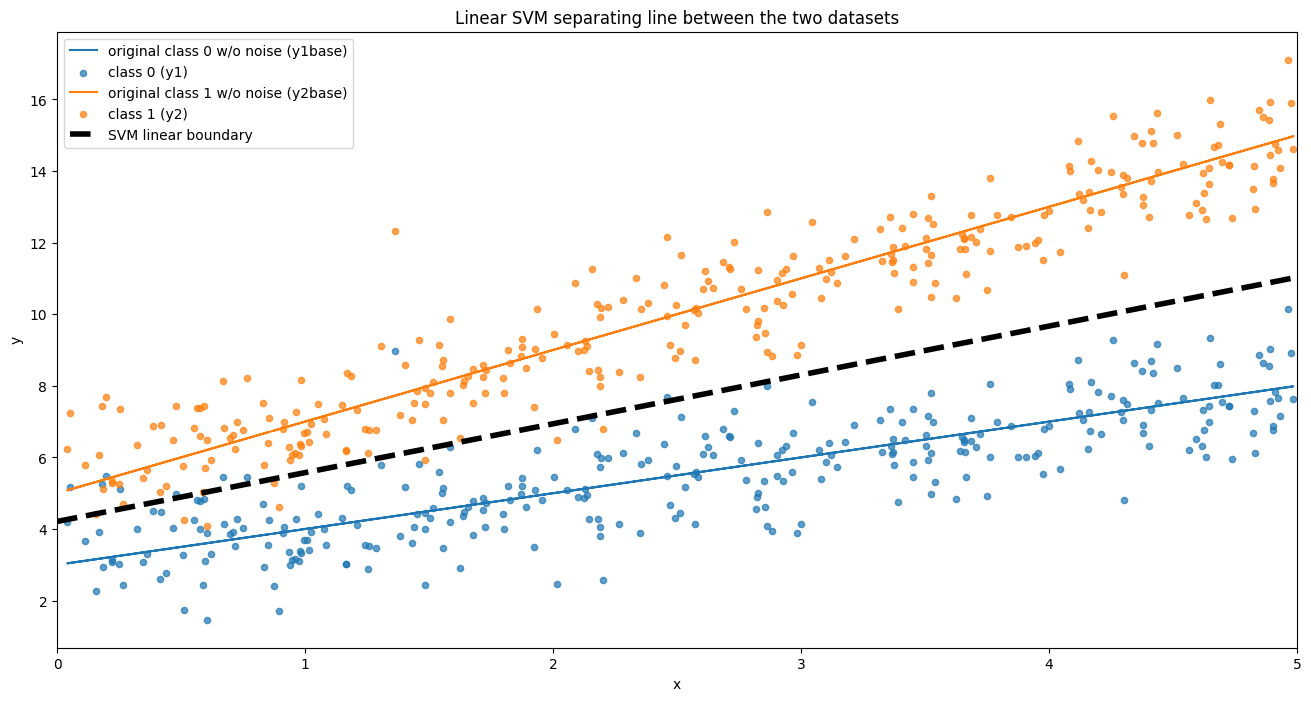

Decision boundary (original space):  y = 1.364 * x + 4.211


In [4]:
# combine two datasets into one with labels:
X_cls = np.vstack([
    np.column_stack([x, y1]),  # class 0
    np.column_stack([x, y2])   # class 1
])
y_cls = np.hstack([np.zeros(N, dtype=int), np.ones(N, dtype=int)])

# --- linear SVM classifier ---
clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="linear", C=1.0, random_state=0)
)
clf.fit(X_cls, y_cls)

# Extract separating line in original (x,y) space:
# For a linear SVM, decision function: w1*x + w2*y + b = 0  =>  y = -(w1/w2)*x - b/w2
# Coefficients live *after* the scaler; to get a readable line in original units,
# we can sample x and get the boundary by solving decision_function=0 numerically.
# Simpler: compute w,b in scaled space, but draw by transforming points through pipeline.
# We'll just compute on a dense grid in original space.

xx = np.linspace(0, 5, 400)
# For each xx, find yy on the boundary by solving w1*x + w2*y + b = 0 in *scaled* space.
# We'll transform points (x, y_guess) iteratively; but easier is to use the analytic form:
# Get w,b in scaled feature space:
svm = clf.named_steps["svc"]
scaler = clf.named_steps["standardscaler"]

w = svm.coef_[0]
b = svm.intercept_[0]

# To draw the boundary in original coordinates, we can use the fact that:
# z = (X - mean)/scale; let X=[x, y].
# Then w·z + b = 0 => w1*(x-μx)/sx + w2*(y-μy)/sy + b = 0
# Solve for y:
# y = μy - (sy/w2) * [ w1*(x-μx)/sx + b ]
mux, muy = scaler.mean_
sx, sy = scaler.scale_

# Handle the (unlikely) case w2 ~ 0
if abs(w[1]) < 1e-12:
    # vertical-like boundary (rare here); skip drawing
    yy = np.full_like(xx, np.nan)
else:
    yy = muy - (sy / w[1]) * (w[0] * (xx - mux) / sx + b)

# --- plot ---
plt.figure(figsize=(16, 8))

plt.plot(x, y1base, label="original class 0 w/o noise (y1base)")
plt.scatter(x, y1, s=20, alpha=0.7, label="class 0 (y1)")

plt.plot(x, y2base, label="original class 1 w/o noise (y2base)")
plt.scatter(x, y2, s=20, alpha=0.7, label="class 1 (y2)")

plt.plot(xx, yy, "k--", lw=4, label="SVM linear boundary")
plt.xlim(0, 5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Linear SVM separating line between the two datasets")
plt.show()

if abs(w[1]) >= 1e-12:
    m = - (sy / w[1]) * (w[0] / sx)
    c = muy - (sy / w[1]) * b + (sy / w[1]) * (w[0]*mux / sx)
    print(f"Decision boundary (original space):  y = {m:.3f} * x + {c:.3f}")
